In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Are we using a GPU
!nvidia-smi

Wed Nov 10 20:53:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Download the data (10% of 10 food classes ip file)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-11-10 20:53:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 66.102.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   122MB/s    in 1.3s    

2021-11-10 20:53:38 (122 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#Food-101 dataset with 10 classes (10% data only)
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print (f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
#Preparing the data

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/train/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical')
print("Testing Images")
test_data_10_percent = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical')

Training Images
Found 750 images belonging to 10 classes.
Testing Images
Found 750 images belonging to 10 classes.


Setting up callbacks (things to run whilst our model trains)

In [ ]:
#Create a functions to track the Tensorboard callback

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to : {log_dir}")
  return tensorboard_callback

Creating models using Tensorflow Hub (A set of pre-trained models)



In [ ]:
#Lets pull efficientnet and resnet network links from Tensorflow hub and put together a model

efficientnet_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [ ]:
#Import dependencies
import tensorflow_hub as hub

#Lets make a create_model function to create the model
def create_model(model_url, num_classes):
  """
  Takes a TensorFlow hub URL and create a Keras sequential model.
  """
  #pretrained model as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, trainable=False, name='feature_extractor_layer', input_shape = IMAGE_SHAPE+(3,))  #freeze already learnt patterns

  #Create our own Sequentail layer
  model = tf.keras.models.Sequential([
                                      feature_extractor_layer,
                                      tf.keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax, name='output_layer')
  ])

  return model

In [ ]:
#Creating a ResNet TensorFlow Hub feature extraction model
resnet_model = create_model(model_url=resnet_url, num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
#Compile the created model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
#Fit the model
history_resnet = resnet_model.fit(train_data_10_percent, 
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent), 
                                  validation_data=test_data_10_percent, 
                                  validation_steps=len(test_data_10_percent), 
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resnet50V2")])

Saving Tensorboard log files to : tensorflow_hub/resnet50V2/20211110-205353
Epoch 1/5
24/24 [==============================] - 46s 518ms/step - loss: 1.8912 - accuracy: 0.3587 - val_loss: 1.0889 - val_accuracy: 0.6427
Epoch 2/5
24/24 [==============================] - 10s 438ms/step - loss: 0.8948 - accuracy: 0.7093 - val_loss: 0.6608 - val_accuracy: 0.8093
Epoch 3/5
24/24 [==============================] - 10s 436ms/step - loss: 0.6179 - accuracy: 0.8053 - val_loss: 0.4934 - val_accuracy: 0.8573
Epoch 4/5
24/24 [==============================] - 10s 438ms/step - loss: 0.4759 - accuracy: 0.8680 - val_loss: 0.4009 - val_accuracy: 0.9027
Epoch 5/5
24/24 [==============================] - 10s 436ms/step - loss: 0.3910 - accuracy: 0.8920 - val_loss: 0.3159 - val_accuracy: 0.9320


In [ ]:
#Lets create a function to plot loss curves of both training and validation

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training loss')
  plt.plot(epochs, val_loss, label='validation loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training accuracy')
  plt.plot(epochs, val_accuracy, label='validation accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

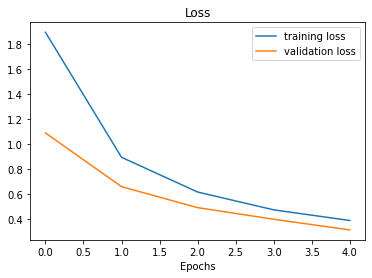

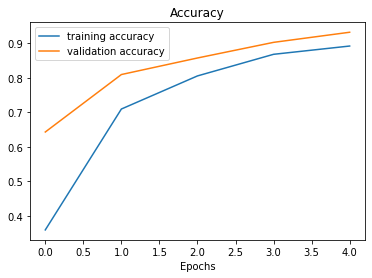

In [ ]:
plot_loss_curves(history_resnet)

Now creating and testing efficientnet and see how it works

In [ ]:
#Creating a EfficientNet TensorFlow Hub feature extraction model
efficientnet_model = create_model(model_url=efficientnet_url, num_classes=train_data_10_percent.num_classes)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
#Compile the created model
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
#Fit the model
history_efficientnet = efficientnet_model.fit(train_data_10_percent, 
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent), 
                                  validation_data=test_data_10_percent, 
                                  validation_steps=len(test_data_10_percent), 
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="efficientnetb0")])

Saving Tensorboard log files to : tensorflow_hub/efficientnetb0/20211110-205528
Epoch 1/5
24/24 [==============================] - 16s 442ms/step - loss: 1.8458 - accuracy: 0.4427 - val_loss: 1.2999 - val_accuracy: 0.7173
Epoch 2/5
24/24 [==============================] - 9s 383ms/step - loss: 1.0702 - accuracy: 0.7693 - val_loss: 0.8472 - val_accuracy: 0.8200
Epoch 3/5
24/24 [==============================] - 9s 383ms/step - loss: 0.7634 - accuracy: 0.8360 - val_loss: 0.6558 - val_accuracy: 0.8667
Epoch 4/5
24/24 [==============================] - 9s 382ms/step - loss: 0.6139 - accuracy: 0.8653 - val_loss: 0.5451 - val_accuracy: 0.8773
Epoch 5/5
24/24 [==============================] - 9s 383ms/step - loss: 0.5215 - accuracy: 0.8787 - val_loss: 0.4669 - val_accuracy: 0.9053


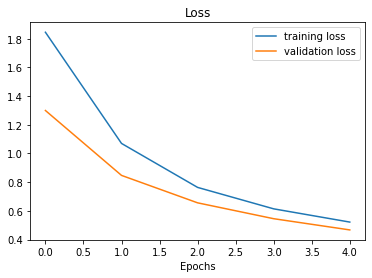

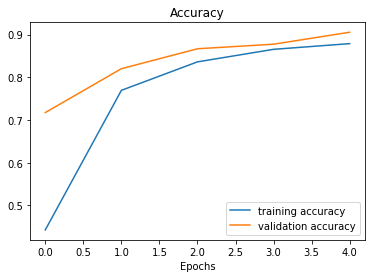

In [ ]:
plot_loss_curves(history_efficientnet)

##Now lets try to use Tensorboard and compare the results from both the models developed above

In [ ]:
#Upload Tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EffecientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=8PvoNzFuXPbAbHviFT0BIcsyrrErgY&prompt=consent&access_type=off

In [ ]:
#List all the experiments that are on tensorboard
!tensorboard dev list

https://tensorboard.dev/experiment/NqfNTz5TRByQtL4mpoJnoA/
	Name                 EffecientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models
	Id                   NqfNTz5TRByQtL4mpoJnoA
	Created              2021-11-10 21:25:31 (7 minutes ago)
	Updated              2021-11-10 21:25:34 (7 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3138469
Total: 1 experiment(s)


In [ ]:
#Delete an experiment on Tensorboard
#!tensorboard dev delete --experiment_id NqfNTz5TRByQtL4mpoJnoA